# Orientations points test

In [1]:
import jax
import jax.numpy as jnp
from jax.config import config
import numpy as np
from matplotlib import pyplot as plt
import mrcfile

from simplecryoem.projection import project
from simplecryoem.utils import create_3d_mask, plot_angles
from simplecryoem.fsc import (
    points_orientations_nn,
    points_orientations_tri,
    points_orientations_star,
)

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### Some basic objects and the angles

In [3]:
N = 1000
nx = 64
ones3 = jnp.ones([nx, nx, nx])
ones2 = jnp.ones([nx, nx])
x_grid = np.array([0.05, nx])
shifts = jnp.zeros([N, 3])
ctf_params = None

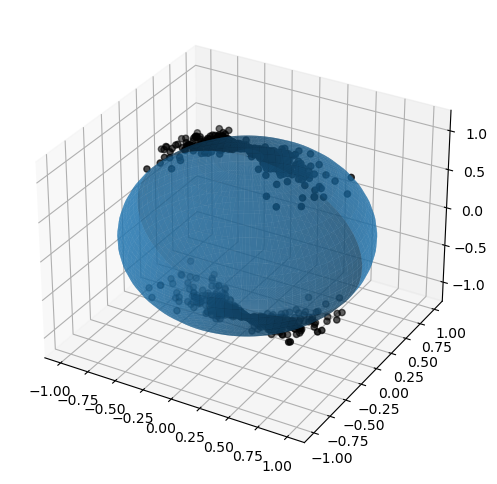

In [4]:
s = 0.3
# angles = jnp.array(np.random.rand(N,3))*jnp.pi*2
# angles_true = s*np.random.randn(int(N),3)
angles = np.concatenate(
    [s * np.random.randn(int(N / 2), 3), s * np.random.randn(int(N / 2), 3) + np.pi],
    axis=0,
)
np.random.shuffle(angles)
angles = jnp.array(angles)

plot_angles(angles[:1000])

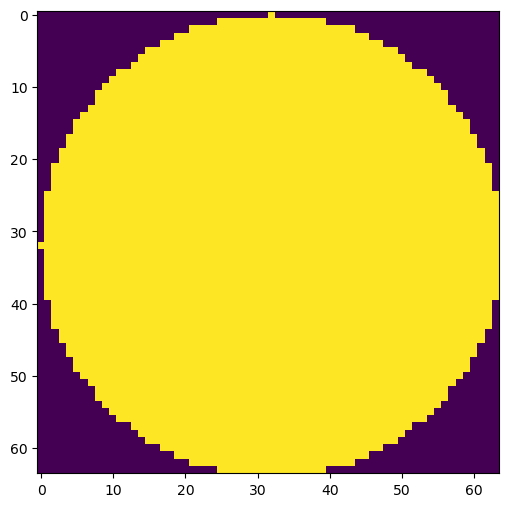

In [5]:
radius = 1.6
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
plt.imshow(jnp.fft.fftshift(mask[:, :, 0]))

### Obtain the points touched by the NN interpolation using the ajoint operator

In [6]:
# For one orientation-shifts pair
def get_nn_points_idx(ang, sh):
    slice_nn = lambda v: project(v, ang, sh, None, x_grid, x_grid, "nn")
    jac = jax.jacfwd(slice_nn)(ones3)
    c = jac.reshape(nx * nx, -1).T @ ones2.reshape(nx * nx, 1)
    return c.reshape(nx, nx, nx)

In [ ]:
# And for the full angles & shifts array
points_adj = jax.vmap(get_nn_points_idx, in_axes=(0, 0))(angles, shifts)
points_adj = jnp.real(jnp.sum(points_adj, axis=0))

In [ ]:
plt.imshow(np.fft.fftshift(points_adj[:, :, 0]))
plt.colorbar()

In [ ]:
plt.imshow(np.fft.fftshift(points_adj[:, 0, :]))
plt.colorbar()

### And compare with the points generated by the the function

In [ ]:
points_nn = points_orientations_nn(angles, nx)

In [ ]:
assert jnp.sum(jnp.abs(points_nn - points_adj)) == 0

### Trilinear interpolation

In [ ]:
points_tri = points_orientations_tri(angles, nx)

In [ ]:
points_tri = points_tri / jnp.max(points_tri) * mask

In [ ]:
plt.imshow(np.fft.fftshift(points_tri[:, :, 0]))
plt.colorbar()

In [ ]:
plt.imshow(np.fft.fftshift(points_tri[:, 0, :]))
plt.colorbar()

### From star file

In [ ]:
# data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
# star_file = "Extract/job020/particles.star"

data_dir = "../data/"
star_file = "particles.star"

points_star = points_orientations_star(data_dir, star_file, nx=64)

In [ ]:
nx = 64
x_grid = np.array([0.05, nx])
radius = 1.6
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
ps = jnp.fft.fftshift(points_star * mask)
# ps = ps/jnp.max(ps)

In [ ]:
plt.imshow(jnp.log(ps[:, :, 32]))
plt.colorbar()

In [ ]:
with mrcfile.open("../data/vol2_daniel.mrcs") as f:
    v1 = f.data

In [ ]:
v1.shape

In [ ]:
m1 = mrcfile.open("../data/vol3_daniel.mrcs")

In [ ]:
m1.is_volume()